# Data Loading and Quick Look at the Structure

In [1]:
import pandas as pd
import random

random.seed(42)      # We set the random seed to some constant number for reproducible results

train_data = pd.read_csv("./vaccine_train_set.csv").drop(columns=["Unnamed: 0"])
validation_data = pd.read_csv("./vaccine_validation_set.csv").drop(columns=["Unnamed: 0"])
test_data = pd.read_csv("./vaccine_validation_set.csv").drop(columns=["Unnamed: 0"])

In [2]:
train_data.head()    # 0 = Neutral, 1 = Anti-Vax, 2 = Pro-Vax

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


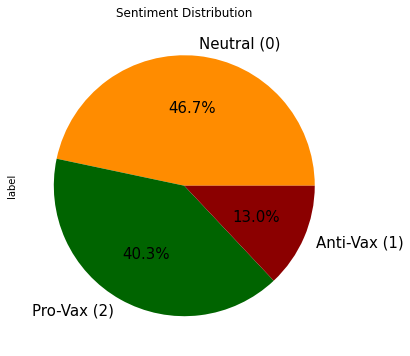

In [3]:
label_sentiments = {0: "Neutral (0)", 1: "Anti-Vax (1)", 2: "Pro-Vax (2)"}   # Make a dictionary mapping each label to its sentiment
plot = train_data['label'].value_counts().rename(index=label_sentiments).plot(kind='pie',figsize=(6,6), fontsize=15, colors=['darkorange','darkgreen','darkred'], title='Sentiment Distribution', autopct='%1.1f%%')

# Data Exploration

Let's see visualize the most frequent words in our training data.

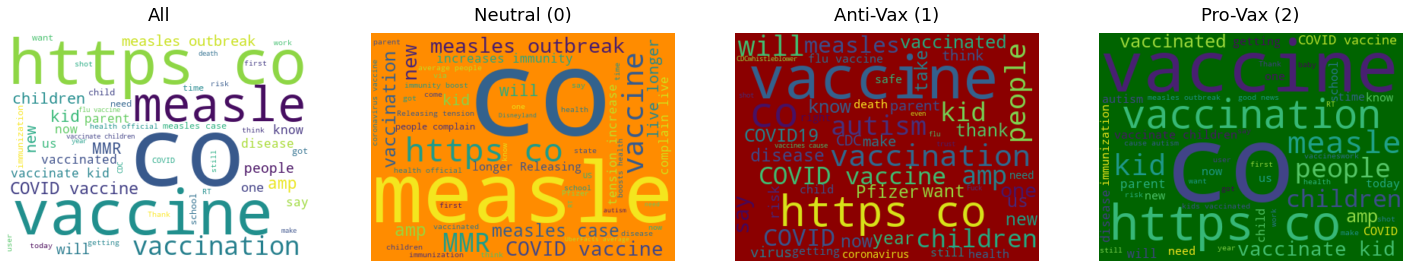

In [4]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

exploration_data = train_data.copy()    # Get a copy of the training data

all_tweets = " ".join(i for i in exploration_data['tweet'])
neutral_tweets = " ".join(i for i in exploration_data['tweet'][exploration_data['label'] == 0])
negative_tweets = " ".join(i for i in exploration_data['tweet'][exploration_data['label'] == 1])
positive_tweets = " ".join(i for i in exploration_data['tweet'][exploration_data['label'] == 2])

wordcloud_all = WordCloud(max_words=50, height=300, background_color = 'white', stopwords = stopwords).generate(all_tweets)
wordcloud_neutral = WordCloud(max_words=50, height=300, background_color = 'darkorange', stopwords = stopwords).generate(neutral_tweets)
wordcloud_negative = WordCloud(max_words=50, height=300, background_color = 'darkred', stopwords = stopwords).generate(negative_tweets)
wordcloud_positive = WordCloud(max_words=50, height=300, background_color = 'darkgreen', stopwords = stopwords).generate(positive_tweets)

plt.figure(figsize = (25,30))
for i, wordcloud, title in [(1, wordcloud_all, 'All'), (2, wordcloud_neutral, 'Neutral (0)'), (3, wordcloud_negative, 'Anti-Vax (1)'), (4, wordcloud_positive, 'Pro-Vax (2)')]:
    plt.subplot(1,4,i)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize = 18, y = 1.03)
    plt.axis("off")
plt.show()

The above visualizations don't look very informative. Firstly, there's a high overlap of individual words between the different categories. This is quite expected considering that even strong words like 'autism' can appear in both Anti-Vax and Pro-Vax tweets as 'vaccines cause autism' and 'vaccines don't cause autism' respectively, hence n-grams like bigrams would probably be much more informative than individual words. Secondly, there's quite some noise in our data, like links (https), that appear too often in our tweets and don't really offer any insights, therefore we'd probably have to clean our data before feeding them to our classification algorithms.

Now let's try to find and visualize the types of noise tweets can possibly have, like:
- tags (@)
- links (http,https,www)
- hashtags (some could be useful though)
- emojis
- emoticons :-)

In [5]:
import re
%pip install emoji
import emoji

def find_urls(tweet):
    """
    Searches for urls (http,https,www) in a tweet .
    """
    url_pattern = re.compile(r'http\S+|www\S+|https\S+')
    return re.search(url_pattern,tweet)

def find_hashtags(tweet):
    """
    Searches for hashtags (#) in a tweet.
    """
    hashtag_pattern = re.compile(r'#(\w+)')
    return re.search(hashtag_pattern,tweet)

def find_tags(tweet):
    """
    Searches for tags (@) in a tweet.
    """
    tag_pattern = re.compile(r'@[^\s]+')
    return re.search(tag_pattern,tweet)

def find_emojis(tweet):
    """
    Searches for emojis in a tweet.
    """
    emoji_pattern = emoji.get_emoji_regexp()
    return re.search(emoji_pattern,tweet)

     |████████████████████████████████| 170 kB 5.5 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=88ddcaa3ed98b4474ee750c39315eb2bd813d153862b9527f284c2db79db2803
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji


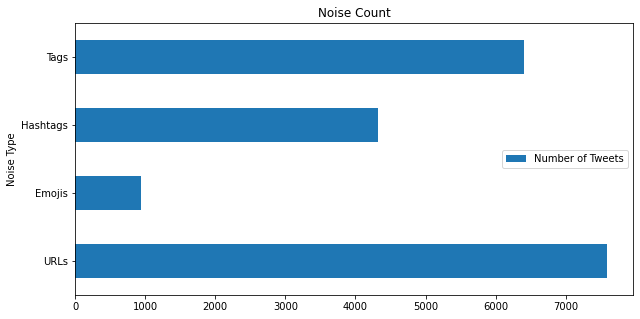

In [6]:
urls = exploration_data['tweet'].apply(find_urls).notnull().sum()
emojis = exploration_data['tweet'].apply(find_emojis).notnull().sum()
hashtags = exploration_data['tweet'].apply(find_hashtags).notnull().sum()
tags = exploration_data['tweet'].apply(find_tags).notnull().sum()
df_noise = pd.DataFrame({'Noise Type': ['URLs', 'Emojis', 'Hashtags', 'Tags'], 'Number of Tweets': [urls, emojis, hashtags,tags]})
df_noise.plot.barh(x='Noise Type', y='Number of Tweets',figsize=(10,5), title='Noise Count');

# Data Preparation

## (Task-Specific) Noise Removal

We create custom transformers for each preparation step in order to create preparation pipelines and later treat our preparation steps as hyperparameters for fine-tuning our best model.

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

class URLRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the urls from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the urls in all the tweets
            - None: Does nothing. No urls are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            url_pattern = re.compile(r'http\S+|www\S+|https\S+')
            return X_rem.apply(lambda tweet: url_pattern.sub(r'',tweet))
        return X
    
class HashtagRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the hashtags from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the hashtags in all the tweets.
            - None: Does nothing. No hashtags are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            hashtag_pattern = re.compile(r'#(\w+)')
            return X_rem.apply(lambda tweet: hashtag_pattern.sub(r'',tweet))
        return X

class TagRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the tags from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the tags in all the tweets.
            - None: Does nothing. No tags are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            tag_pattern = re.compile(r'@[^\s]+')
            return X_rem.apply(lambda tweet: tag_pattern.sub(r'',tweet))
        return X

class EmojiRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the emojis from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the emojis in all the tweets.
            - Convert: Converts all the emojis to their text representations.
            - None: Does nothing. No emojis are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            if self.strategy == 'Remove':
                emoji_pattern = emoji.get_emoji_regexp()
                return X_rem.apply(lambda tweet: emoji_pattern.sub(r'',tweet))
            elif self.strategy == 'Convert':
                return X_rem.apply(lambda tweet: emoji.demojize(tweet))
        return X

## Normalization

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
Stopwords = set(stopwords.words('english')) # We save them in this variable to speed up the lambda function for removing stopwords. It also helps speed up gridSearch later.
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

class LowercaseConverter(BaseEstimator, TransformerMixin):
    """
    Converts (or not) all tweets to lowercase.
    """
    def __init__(self, strategy='Convert'):
        """
        Available Strategies:
            - Convert: Converts all tweets to lowercase.
            - None: Does nothing. No lowercase conversion takes place.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            return X.str.lower()
        return X      

class PunctuationRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the punctuation from all tweets.
    (In fact, it replaces it with empty space which comes 
    in handy when we convert emojis to their text representations)
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the punctuation in all the tweets.
            - None: Does nothing. No punctuation is removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            X_rem = X.copy()
            punctuation_pattern = re.compile(r'[^\w\s]')
            return X_rem.apply(lambda tweet: punctuation_pattern.sub(r' ',tweet))
        return X
    
class StopwordRemover(BaseEstimator, TransformerMixin):
    """
    Removes (or not) the stopwords from all tweets.
    """
    def __init__(self, strategy='Remove'):
        """
        Available Strategies:
            - Remove: Removes all the stopwords in all the tweets.
            - None: Does nothing. No stopwords are removed.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            return X.apply(lambda tweet: " ".join([word for word in str(tweet).split() if word not in Stopwords]))
        return X    
    
class InflectedFormHandler(BaseEstimator, TransformerMixin):
    """
    Handles the inflected forms of words by using either Stemming or Lemmatization.
    """
    def __init__(self, strategy='Stemming'):
        """
        Available Strategies:
            - Stemming: Uses a stemmer.
            - Lemmatization: Uses a lemmatizer.
            - None: Does nothing. No inflected form handling takes place.
        """
        self.strategy = strategy
    def fit(self, X, y=None):
        return self
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        if self.strategy:
            if self.strategy == 'Stemming':
                return X.apply(lambda tweet: " ".join([stemmer.stem(word) for word in tweet.split()]))
            elif self.strategy == 'Lemmatization':
                return X.apply(lambda tweet: " ".join([lemmatizer.lemmatize(word, pos='v') for word in tweet.split()]))
        return X    

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Vectorization

Load and prepare the Word-Embeddings for usage.

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np      

class Vectorizer(BaseEstimator, TransformerMixin):
    """
    Vectorizes the data using Bag of Words, TF-IDF or Pre-Trained Word-Embeddings.
    """
    def __init__(self, strategy='BoW', ngram_range=(1,1), min_df=1, max_df=1.0, dimensions=None):
        """
        Available Strategies:
            - BoW: Bag of Words.
            - TF-IDF: TF-IDF,
            - Word-Embeddings: Pre-trained GloVe Twitter Word Embeddings.
        ngram_range: the ngram_range parameter e.g. ngrams=(1, 1)=only unigrams, (1, 2)=unigrams and bigrams
        min_df: minimum number of tweets a word must be present in to be considered a feature
        max_df: maximum number of tweets a word can be present in to be considered a feature
        dimensions: 25 or 50 or 100 or 200, depending on how many dimensions (i.e. which file) to use for the word-embeddings
        """
        self.strategy = strategy
        self.ngram_range = ngram_range
        self.min_df = min_df
        self.max_df = max_df
        self.vectorizer = None                  # Used only when strategy is either BoW or TF-IDF
        self.dimensions = dimensions
    def fit(self, X, y=None):
        """
        Initiates the vectorizer to the chosen method (bow or tfidf) and then only fits the vectorizer 
        on the data (no transform). This way we can 'fit_transform' on the training data and only call 
        'transform' on the validation data.
        """
        if self.strategy == 'BoW':
            self.vectorizer = CountVectorizer(analyzer='word', ngram_range=self.ngram_range, min_df=self.min_df, max_df=self.max_df)
            self.vectorizer.fit(X)
        elif self.strategy == 'TF-IDF':
            self.vectorizer = TfidfVectorizer(analyzer='word', ngram_range=self.ngram_range, min_df=self.min_df, max_df=self.max_df)
            self.vectorizer.fit(X)
        # If strategy is 'Word-Embeddings', we don't do anything during 'fit'
        return self
    def transform(self, X):
        """
        Transforms the data using the -already fit- vectorizer of the class.
        """
        X_vec = X.copy()
        if self.strategy == 'BoW' or self.strategy == 'TF-IDF':
            X_vec =  self.vectorizer.transform(X_vec)
        else:
            # Initialize the all vectorized tweets to zeros
            X_vec = np.zeros((len(X),self.dimensions))
            # For each tweet in the dataset
            for index, tweet in enumerate(X):
                valid_words_num = 0                                                         # Number of words in this tweet that are in GloVe's vocabulary
                word_vectors = np.zeros(self.dimensions)
                # For each word in this particular tweet
                for word in tweet.split():
                    # If the word is the GloVe's vocabulary
                    if word in all_embeddings_dict[self.dimensions].keys():
                        valid_words_num += 1
                        # Add this word's vector to the whole tweet's vector (Vertically)
                        word_vectors = np.vstack((word_vectors,all_embeddings_dict[self.dimensions][word])) if valid_words_num > 1 else all_embeddings_dict[self.dimensions][word]
                # Get the mean over the 0 axis (i.e. one value per dimension)
                X_vec[index] = word_vectors.mean(axis=0) if valid_words_num > 1 else word_vectors
        return X_vec

## Convertion to Tensors

# Model Selection and Training

Functions for attention.

In [10]:
import torch.nn.functional as F

NEG_INF = -10000
TINY_FLOAT = 1e-6

def mask_softmax(matrix, mask=None):
    """
    Performs softmax on length dimension with masking.
    """
    if mask is None:
        result = F.softmax(matrix, dim=-1)
    else:
        mask_norm = ((1 - mask) * NEG_INF).to(matrix)
        for i in range(matrix.dim() - mask_norm.dim()):
            mask_norm = mask_norm.unsqueeze(1)
        result = F.softmax(matrix + mask_norm, dim=-1)
    return result

def mask_mean(seq, mask=None):
    """
    Compute mask average on length dimension.
    """
    if mask is None:
        return torch.mean(seq, dim=1)
    mask_sum = torch.sum(seq * mask.unsqueeze(-1).float(), dim=1)
    seq_len = torch.sum(mask, dim=-1)
    mask_mean = mask_sum / (seq_len.unsqueeze(-1).float() + TINY_FLOAT)

    return mask_mean

def mask_max(seq, mask=None):
    """
    Computes mask -max- on length dimension.
    """
    if mask is None:
        return torch.mean(seq, dim=1)
    torch
    mask_max, _ = torch.max(seq + (1 - mask.unsqueeze(-1).float()) * NEG_INF, dim=1)
    return mask_max

def seq_mask(seq_len, max_len):
    """
    Creates sequence mask.
    """
    idx = torch.arange(max_len).to(seq_len).repeat(seq_len.size(0), 1)
    mask = torch.gt(seq_len.unsqueeze(1), idx).to(seq_len)
    return mask

The neural network

In [11]:
import torch
import torch.nn as nn

class BidirectionalRNN(nn.Module):
    def __init__(self, cell_type, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout_proba, pad_idx, attention = False):
      
        super(BidirectionalRNN, self).__init__()
        
        # Save the hyperparameters
        self.cell_type = cell_type
        self.input_dim = vocab_size 
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.attention = attention

        # Possible RNN cells
        cells = {
            "RNN"  : nn.RNN, 
            "LSTM" : nn.LSTM,
            "GRU"  : nn.GRU
        }

        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(X_field.vocab.vectors, padding_idx = pad_idx)
        
        # RNN layer
        self.rnn = cells[cell_type](
                                    input_size = embedding_dim,                             # Number of expected features in the input
                                    hidden_size = hidden_dim,                               # Number of features in the hidden state
                                    num_layers = n_layers,                                  # Number of recurrent layers (i.e. stacked RNNs)
                                    bidirectional = True,                                   # The assignment asks for bidirectional RNN specifically
                                    dropout = dropout_proba                                 # Dropout on the outputs of each RNN layer except the last one
                                   )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_proba)

        # First dense layer
        self.dense = nn.Linear(hidden_dim * 2, 32)
        
        # Output layer
        self.out = nn.Linear(32, output_dim)

        # ReLu Activation Layer
        self.relu = nn.ReLU()
        
        # Attention layer
        self.attention = nn.Linear(hidden_dim * 2, output_dim)

        # Softmax activation function layer
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, X, X_lengths):
        # Transform the input to embeddings by passing it to the embedding layer
        embedded = self.dropout(self.embedding(X))
        # embedded = self.embedding(X)
        
        # Pack sequence to ignore gradients calculation for the padded values
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, X_lengths.to('cpu'))
        
        if self.cell_type == 'LSTM':
          packed_output, (h_n, c_n) = self.rnn(packed_embedded)
        else:
          packed_output, h_n = self.rnn(packed_embedded)

        # Take the last hidden state of the forward output and the last hidden state of the backward output and merge them together
        cat = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim = 1)                          # h_n = last hidden states of each of the LSTM layers

        if self.attention == True:
          # Unpack Sequence (use it only for the output in attention, otherwise not needed because of cat function above)
          output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
          
          # Batch-size first in order to pass it into the attention util functions
          output = output.permute(1,0,2)

          max_seq_len = torch.max(output_lengths)
          mask = seq_mask(output_lengths, max_seq_len)

          # Attention
          atten = self.attention(output).squeeze(-1)
          atten = mask_softmax(atten, mask)
          attention_output = torch.sum(atten.unsqueeze(-1) * output, dim=1)

          rel = self.relu(attention_output)
          dense1 = self.dense(rel)
          drop = self.dropout(dense1)
          preds = self.out(drop)
          return self.softmax(preds)          
        else:
          rel = self.relu(cat)
          dense1 = self.dense(rel)
          drop = self.dropout(dense1)
          preds = self.out(drop)
          return self.softmax(preds)

Train/Validation Loops

In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

def train_loop(dataloader, model, loss_fn, optimizer, device, clip_value=1):
    """
    Performs a -single- training iteration (epoch) of the network over all the batches. That is, it performs a forward propagation, 
    computes the error, computes the metric scores (e.g. f1, precision etc) -over the training dataset- for later plotting and then
    updates the parameters using backpropagation. The update takes place per batch. The function returns the (avg. over the batches) 
    scores for each of the metrics on the validation dataset.
    """
    num_batches, sum_losses, sum_f1s, sum_precisions, sum_recalls = (len(dataloader),0,0,0,0)
    model.train()
    for (X,X_length), y in dataloader:
        # Transfer tensors to the specified device
        X = X.to(device)
        y = y.to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Compute prediction and loss
        pred = model(X, X_length)
        loss = loss_fn(pred,y)

        # Compute metric scores
        sum_losses += loss.item()
        sum_f1s += f1_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted', zero_division=0)
        sum_precisions += precision_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted', zero_division=0)
        sum_recalls += f1_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted', zero_division=0)

        # Backpropagation
        loss.backward()
        if clip_value:
            torch.nn.utils.clip_grad_value_(model.parameters(), clip_value)
        optimizer.step()

    return sum_losses/num_batches, sum_f1s/num_batches, sum_precisions/num_batches, sum_recalls/num_batches

def validation_loop(dataloader, model, loss_fn, device):
    """
    Performs a -single- validation iteration (epoch) of the network over all the batches. That is, it performs a forward propagation
    to make the predictions and compute the metric scores -over the validation dataset- for later plotting. We don't update any parameters
    because there's no training taking place, only prediction, to evaluate our model after each epoch. The predictions also take place per
    batch. The function returns the (avg. over the batches) scores for each of the metrics on the validation dataset.
    """
    num_batches, sum_losses, sum_f1s, sum_precisions, sum_recalls = (len(dataloader),0,0,0,0)
    model.eval()
    with torch.no_grad():
        for (X,X_length), y in dataloader:
            # Transfer tensors to the specified device
            X = X.to(device)
            y = y.to(device)
            
            # Compute prediction
            pred = model(X, X_length)

            # Compute metric scores
            sum_losses += loss_fn(pred,y).item()
            sum_f1s += f1_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted', zero_division=0)
            sum_precisions += precision_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted', zero_division=0)
            sum_recalls += recall_score(y.cpu().numpy(), pred.argmax(1).cpu().numpy(), average='weighted', zero_division=0)

    return sum_losses/num_batches, sum_f1s/num_batches, sum_precisions/num_batches, sum_recalls/num_batches

def train_evaluate_network(train_dataloader, validation_dataloader, model, loss_func, optimizer, epochs, device, clip_value):
    """
    Performs the training of the network and evaluation of it over each epoch. For each epoch, it first performs a train_loop to update
    its parameters and then evaluates the network by performing a validation loop. For each epoch, it saves the metric scores for each
    dataset its corresponding dictionary and metric list. The function returns the train_scores and validation_scores per epoch for
    later plotting.
    """
    train_scores = {'loss':[], 'f1':[], 'precision':[], 'recall':[]}
    validation_scores = {'loss':[], 'f1':[], 'precision':[], 'recall':[]}
    for t in range(epochs):

        # train_dataloader.create_batches()
        train_dataloader.init_epoch()
        # validation_dataloader.create_batches()

        # Update the network's parameters
        train_loss, train_f1, train_precision, train_recall = train_loop(train_dataloader, model, loss_func, optimizer, device, clip_value)

        # Evaluate the updated model on the validation set 
        validation_loss, validation_f1, validation_precision, validation_recall = validation_loop(validation_dataloader, model, loss_func, device)

        # Save the training scores of this epoch
        train_scores['loss'].append(train_loss)
        train_scores['f1'].append(train_f1)
        train_scores['precision'].append(train_precision)
        train_scores['recall'].append(train_recall)
        
        # Save the validation scores of this epoch
        validation_scores['loss'].append(validation_loss)
        validation_scores['f1'].append(validation_f1)
        validation_scores['precision'].append(validation_precision)
        validation_scores['recall'].append(validation_recall)

    return train_scores, validation_scores

def plot_scores(train_scores,validation_scores,epochs,title):
    """
    Plots the training and validation scores per epoch. That is, the loss (as specified by the loss function used during training) over the
    epochs, the f1 scores over the epochs, the precision over the epochs and the recall over the epochs, for each of the two datasets. 
    """
    plt.figure(figsize = (20,4))
    for i,metric in enumerate(['loss','f1','precision','recall']):
        plt.subplot(1,4,i+1)
        plt.plot(range(1,epochs+1), train_scores[f'{metric}'], label = 'Training')
        plt.plot(range(1,epochs+1), validation_scores[f'{metric}'], label = 'Validation')
        plt.ylabel(f'{metric}', fontsize = 12)
        plt.xlabel('epoch', fontsize = 12)
        plt.title(f'{metric} over epochs', fontsize = 12, y = 1.03)
        plt.legend()
    plt.suptitle(title,fontsize=12)
    plt.tight_layout()

Prepare the Data

In [13]:
from sklearn.pipeline import Pipeline
from torchtext.legacy import data
from torchtext.vocab import GloVe

# For reproducible results
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Preprocessing pipeline
preparation_pipeline = Pipeline([
        ('urls', URLRemover()),
        ('hashtags', HashtagRemover()),
        ('tags', TagRemover()),
        ('emojis', EmojiRemover(strategy='Remove')),
        ('lowercase', LowercaseConverter()),
        ('punctuation', PunctuationRemover()),
        ('stopwords', StopwordRemover(strategy=None)),
        ('inflected_forms', InflectedFormHandler(strategy='Lemmatization'))
    ])

# Copy the data
X_train = train_data.copy()['tweet']
y_train = train_data.copy()['label']
X_validation = validation_data.copy()['tweet']
y_validation = validation_data.copy()['label']     
X_test = test_data.copy()['tweet']
y_test = test_data.copy()['label']

# Preprocess the data
X_train = preparation_pipeline.fit_transform(X_train)
X_validation = preparation_pipeline.transform(X_validation)
X_test = preparation_pipeline.transform(X_test)

# Remove the ones that got empty after preprocessing
full_train = pd.merge(X_train, y_train, right_index = True, left_index = True)                   # Holds both the tweets and the labels
full_validation = pd.merge(X_validation, y_validation, right_index = True, left_index = True)
full_test = pd.merge(X_test, y_test, right_index = True, left_index = True)

empty_train_indices = [i for i, train_instance in full_train.iterrows() if len(train_instance['tweet']) == 0]
empty_validation_indices = [i for i, validation_instance in full_validation.iterrows() if len(validation_instance['tweet']) == 0]
empty_test_indices = [i for i, test_instance in full_test.iterrows() if len(test_instance['tweet']) == 0]

full_train.drop(full_train.index[empty_train_indices], inplace=True)
full_validation.drop(full_validation.index[empty_validation_indices], inplace=True)
full_test.drop(full_test.index[empty_test_indices], inplace=True)
        
# Save to .csv to load with TabularDataset
full_train.to_csv("/content/preprocessed_train.csv", index=False)
full_validation.to_csv("/content/preprocessed_validation.csv", index=False)
full_test.to_csv("/content/preprocessed_test.csv", index=False)

# Define Field Objects
X_field = data.Field(tokenize = "spacy", include_lengths = True)
y_field = data.LabelField(dtype=torch.long)

# Load the preprocessed train and validation data
preprocessed_train, preprocessed_validation, preprocessed_test = data.TabularDataset.splits(
    path="/content/", train="preprocessed_train.csv",  validation="preprocessed_validation.csv", test='preprocessed_test.csv', format="csv", skip_header=True, 
    fields=[('X', X_field), ('y', y_field)]
)

# Download the pre-trained embeddings
glove = GloVe(name='twitter.27B', dim=200)

# Build the vocabulary using GloVe
X_field.build_vocab(preprocessed_train, vectors=glove, unk_init = torch.Tensor.zero_ )#, max_size = 2500)
y_field.build_vocab(preprocessed_train)

# Use cuda if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the dataloaders using BucketIterator (which batches similar length tweets together)
buckit_train_dataloader, buckit_validation_dataloader, buckit_test_dataloader = data.BucketIterator.splits(
                              # Datasets for iterator to draw data from
                              (preprocessed_train, preprocessed_validation, preprocessed_test),
                              # Tuple of train and validation batch sizes.
                              batch_size=64,
                              # Device to load batches on.
                              device=device, 
                              # Function to use for sorting examples.
                              sort_key=lambda x: len(x.X,),
                              # Sort -all- examples in data using `sort_key`.
                              sort=False, 
                              # Shuffle data on each epoch run.
                              # shuffle=True,
                              # Use `sort_key` to sort examples -in each batch-.
                              sort_within_batch=True,
                              )

# Create batches - needs to be called before each loop.
buckit_train_dataloader.create_batches()
buckit_validation_dataloader.create_batches()
buckit_test_dataloader.create_batches()

# Print an example batch (with similar length tweets)
for batch in buckit_train_dataloader.batches:

  # Let's check batch size
  print(f'Batch size: {len(batch)}')
  print('LABEL\tLENGTH\tTEXT'.ljust(10))
  
  # Print each example
  for example in batch:
    print(f'{example.y}\t{len(example.X)}\t{example.X}'.ljust(10))
  
  # Only look at first batch. Reuse this code in training models
  break

.vector_cache/glove.twitter.27B.zip: 1.52GB [04:46, 5.31MB/s]                            
100%|█████████▉| 1193513/1193514 [01:48<00:00, 11027.32it/s]


Batch size: 64
LABEL	LENGTH	TEXT
2	37	['grateful', 'for', 'the', 'fantastic', 'mind', 'work', 'their', 'vaccine', 'magic', 'to', 'restore', 'normality', 'we', 'really', 'be', 'a', 'great', 'many', 'live', 'off', 'the', 'genius', 'of', 'a', 'great', 'few', 'and', 'we', 'should', 'respect', 'those', 'few', 'for', 'their', 'expertise', 'and', 'dedication']
2	37	['masha', 'allah', 'vaccinate', 'today', 'i', 'receive', 'my', 'first', 'dose', 'of', 'covid', '19', 'vaccine', 'of', 'astrazeneca', 'oxford', 'administer', 'by', 'the', 'nphc', 'staff', 'perform', 'at', 'federal', 'university', 'gusau', 'allah', 'ya', 'kara', 'bamu', 'lafiya', 'da', 'zaman', 'lafiya', '30', '03', '2021']
2	37	['today', 'and', 'tomorrow', 'stop', 'by', 'station', '6', 'for', 'your', 'vaccine', 'make', 'an', 'appointment', 'today', 'short', 'wait', 'time', 'and', 'you', 'get', 'to', 'meet', 'our', 'awesome', 'firefighters', 'walk', 'up', 'be', 'accept', 'if', 'dose', 'be', 'available', 'learn', 'more', 'information'

Let's see how the **Number of Stacked RNNs** affects our training.

C:\Users\ioannis.mystakidis\Anaconda3\envs\AI2\lib\site-packages\torch\nn\modules\rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


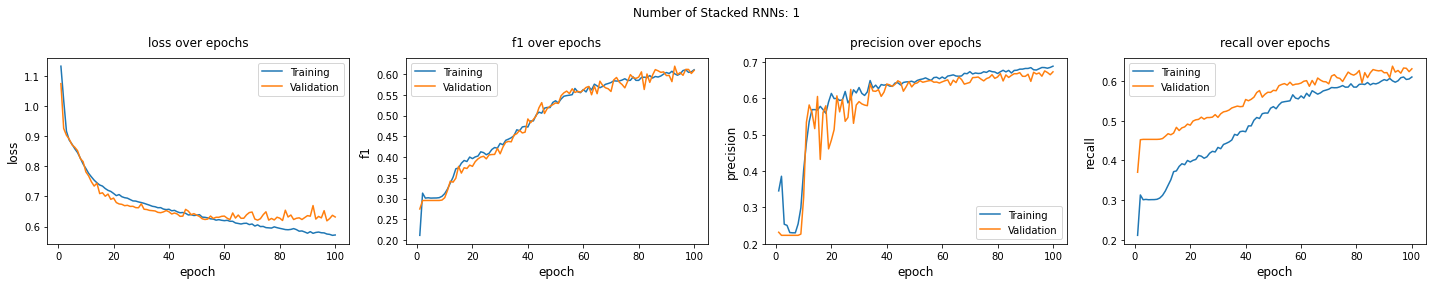

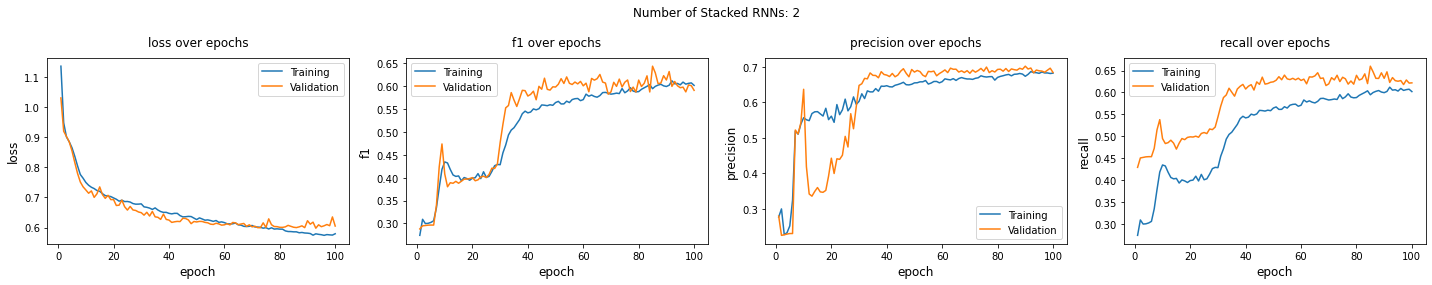

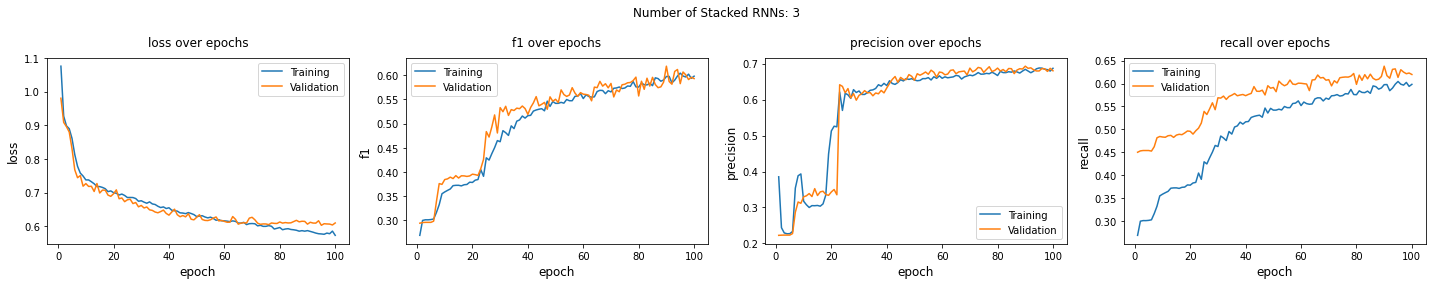

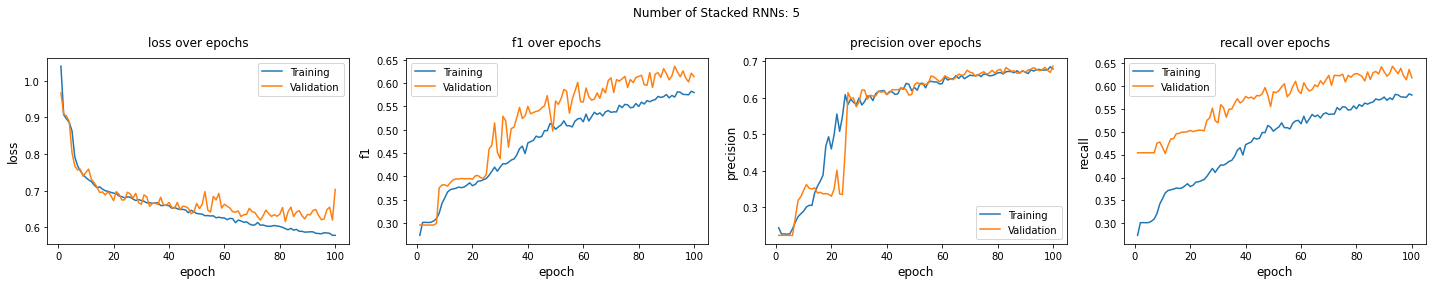

In [ ]:
# Hyperparameters (except number of stacked RNNs)
CELL_TYPE = 'LSTM'                                          # Type of reccurent layer cell
INPUT_DIM = len(X_field.vocab)                              # Vocabulary size (because the first layer is the embedding layer)
EMBEDDING_DIM = X_field.vocab.vectors.shape[1]              # Embeddings dimensions
HIDDEN_DIM = 64                                             # Number of features in the hidden state
OUTPUT_DIM = 3                                              # Number of distinct labels in our data
DROPOUT = 0.5                                               # Dropout probability
PAD_IDX = X_field.vocab.stoi[X_field.pad_token]             # <pad> token index
ATTENTION = False                                           # Adding attention or not
GRAD_CLIP_VALUE = None

# Define the models 
model1 = BidirectionalRNN(CELL_TYPE, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, 1, DROPOUT, PAD_IDX, ATTENTION).to(device)
model2 = BidirectionalRNN(CELL_TYPE, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, 2, DROPOUT, PAD_IDX, ATTENTION).to(device)
model3 = BidirectionalRNN(CELL_TYPE, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, 3, DROPOUT, PAD_IDX, ATTENTION).to(device)
model4 = BidirectionalRNN(CELL_TYPE, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, 5, DROPOUT, PAD_IDX, ATTENTION).to(device)

epochs = 100
for i, (n_layers,model) in enumerate([(1,model1),(2,model2),(3,model3),(5,model4)]):
    # Define the loss function (use the weight parameter because the dataset is imbalanced)
    label_counts = train_data['label'].value_counts()
    weights_list = label_counts[0]/max(label_counts),label_counts[1]/max(label_counts),label_counts[2]/max(label_counts)
    loss_func = nn.NLLLoss(torch.Tensor(weights_list)).to(device)

    # Define the optimizer (use Adam because it is a requirement for the assignment)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Train the Network
    train_scores, validation_scores = train_evaluate_network(buckit_train_dataloader, buckit_validation_dataloader, model, loss_func, optimizer, epochs, device, GRAD_CLIP_VALUE)

    # Plot Loss, F1 Score, Precision and Recall over Epochs for Training/Validation
    plot_scores(train_scores,validation_scores,epochs,f'Number of Stacked RNNs: {n_layers}')

As we can see, stacking more RNNs results in an increase in the performance of our network up to a point where it starts decreasing again. Using more than a single (bidirectional) recurrent layer allows our model to fit better on the training data and our choices for the values of the other hyperparameters (e.g. dropout probability, learning rate etc.) guarantee that we don't overfit. However, stacking up too many layers has the opposite effect and makes it more difficult for our model to learn the intricacies of our data (which a big problem considering the small size of our dataset). In the last plot, it looks like our model is underfitting the data because of the f1 score subplot, but when looking at the loss subplot we can see that the validation loss only increases.

Let's see how the **Number of Hidden Layers** affects the training.

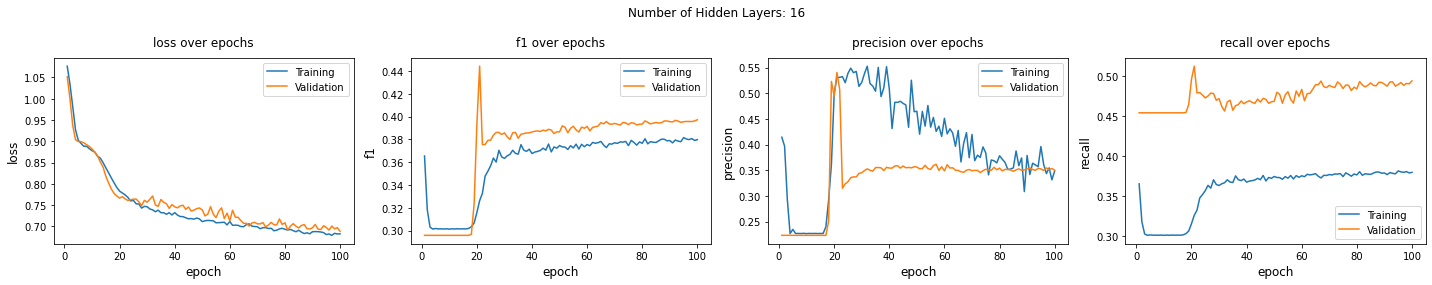

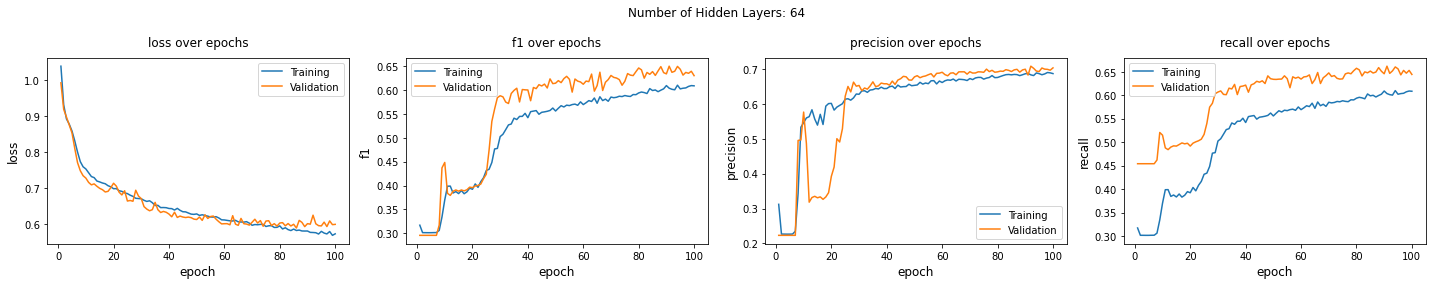

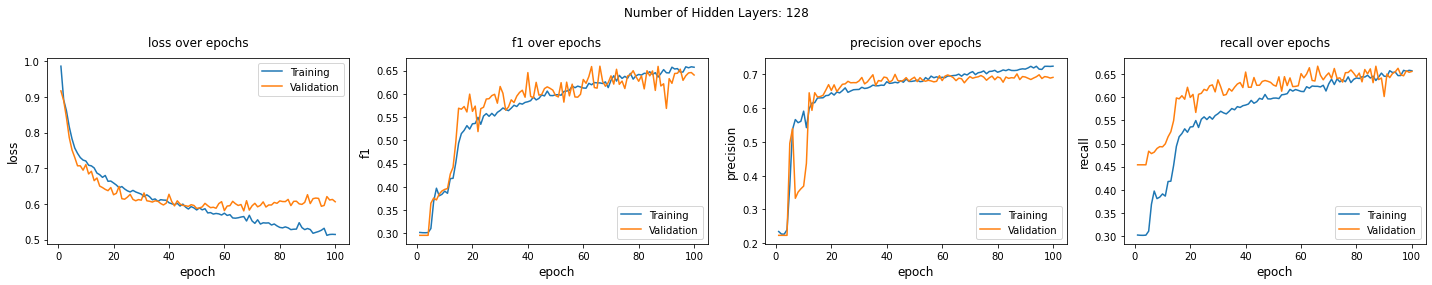

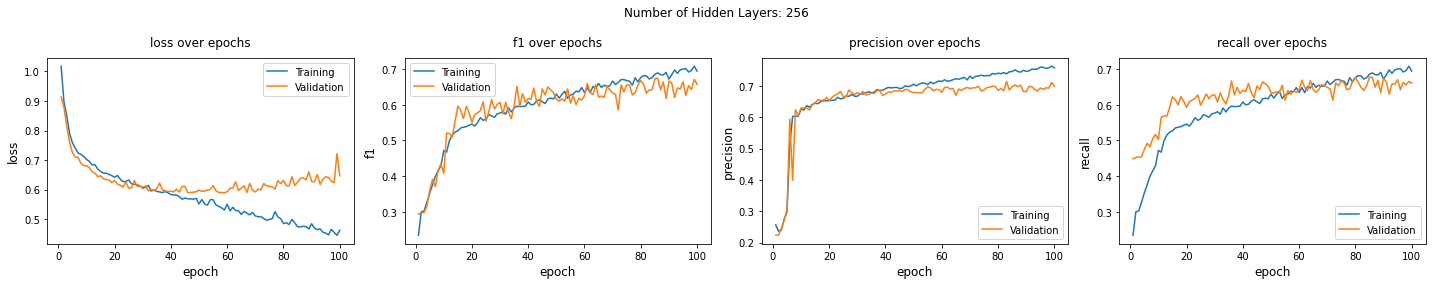

In [ ]:
# Hyperparameters (except number of hidden dimensions)
CELL_TYPE = 'LSTM'                                          # Type of reccurent layer cell
INPUT_DIM = len(X_field.vocab)                              # Vocabulary size (because the first layer is the embedding layer)
EMBEDDING_DIM = X_field.vocab.vectors.shape[1]              # Embeddings dimensions
OUTPUT_DIM = 3                                              # Number of distinct labels in our data
DROPOUT = 0.5                                               # Dropout probability
PAD_IDX = X_field.vocab.stoi[X_field.pad_token]             # <pad> token index
ATTENTION = False                                           # Adding attention or not
N_LAYERS = 2
GRAD_CLIP_VALUE = None

# Define the models 
model1 = BidirectionalRNN(CELL_TYPE, INPUT_DIM, EMBEDDING_DIM, 16, OUTPUT_DIM, N_LAYERS, DROPOUT, PAD_IDX, ATTENTION).to(device)
model2 = BidirectionalRNN(CELL_TYPE, INPUT_DIM, EMBEDDING_DIM, 64, OUTPUT_DIM, N_LAYERS, DROPOUT, PAD_IDX, ATTENTION).to(device)
model3 = BidirectionalRNN(CELL_TYPE, INPUT_DIM, EMBEDDING_DIM, 128, OUTPUT_DIM, N_LAYERS, DROPOUT, PAD_IDX, ATTENTION).to(device)
model4 = BidirectionalRNN(CELL_TYPE, INPUT_DIM, EMBEDDING_DIM, 256, OUTPUT_DIM, N_LAYERS, DROPOUT, PAD_IDX, ATTENTION).to(device)

epochs = 100
for i, (hidden_dim,model) in enumerate([(16,model1),(64,model2),(128,model3),(256,model4)]):
    # Define the loss function (use the weight parameter because the dataset is imbalanced)
    label_counts = train_data['label'].value_counts()
    weights_list = label_counts[0]/max(label_counts),label_counts[1]/max(label_counts),label_counts[2]/max(label_counts)
    loss_func = nn.NLLLoss(torch.Tensor(weights_list)).to(device)

    # Define the optimizer (use Adam because it is a requirement for the assignment)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Train the Network
    train_scores, validation_scores = train_evaluate_network(buckit_train_dataloader, buckit_validation_dataloader, model, loss_func, optimizer, epochs, device, GRAD_CLIP_VALUE)

    # Plot Loss, F1 Score, Precision and Recall over Epochs for Training/Validation
    plot_scores(train_scores,validation_scores,epochs,f'Number of Hidden Layers: {hidden_dim}')

We can see that a small number (16) of hidden layers makes the two loss curves get very close to each other, which means that this model probably generalizes better, but when we look at the f1 subplot of this model, we can see that the scores we get are not ideal. Again, for this hyperparameter, we would like a value not too small and not too big either, for example 64, which results in a small bias and small variance. From the plots it looks like, in general, increasing the number of hidden layers allows our model to fit the data better and leads to higher to smaller bias, but increasing it too much also leads to higher variance. The optimal value obviously depends on the values of the other hyperparameters.

Let's see how the **Type of Cells** affects our training.

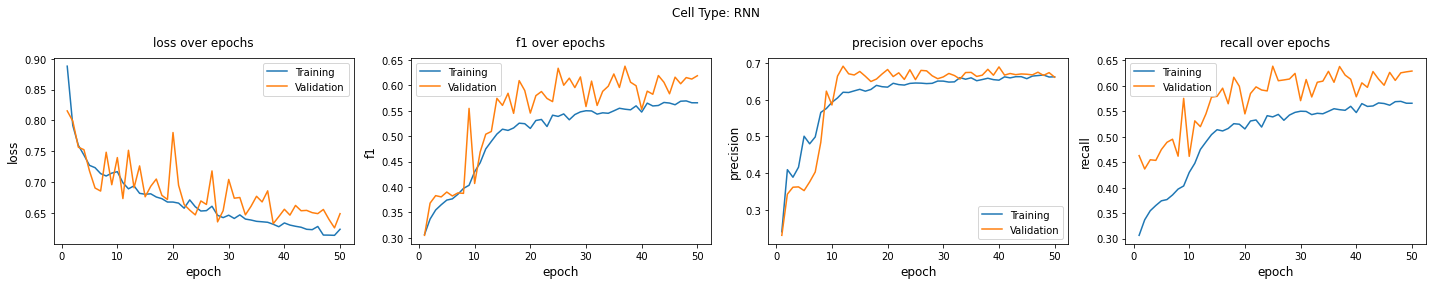

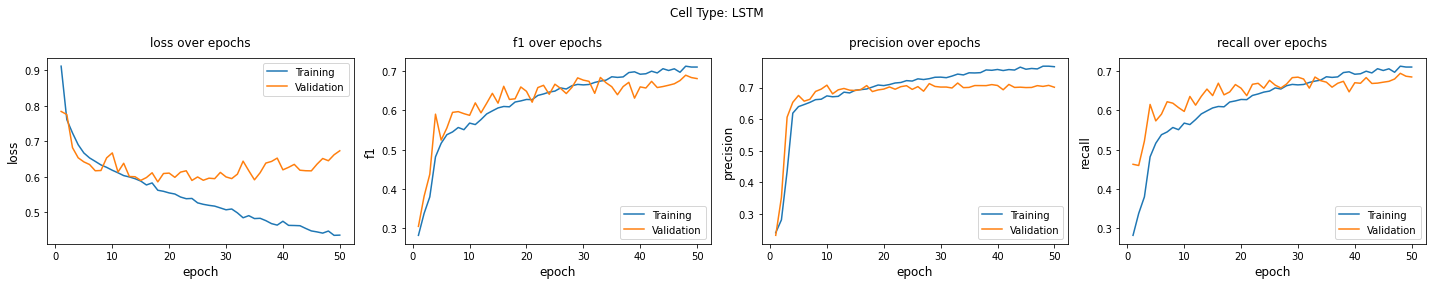

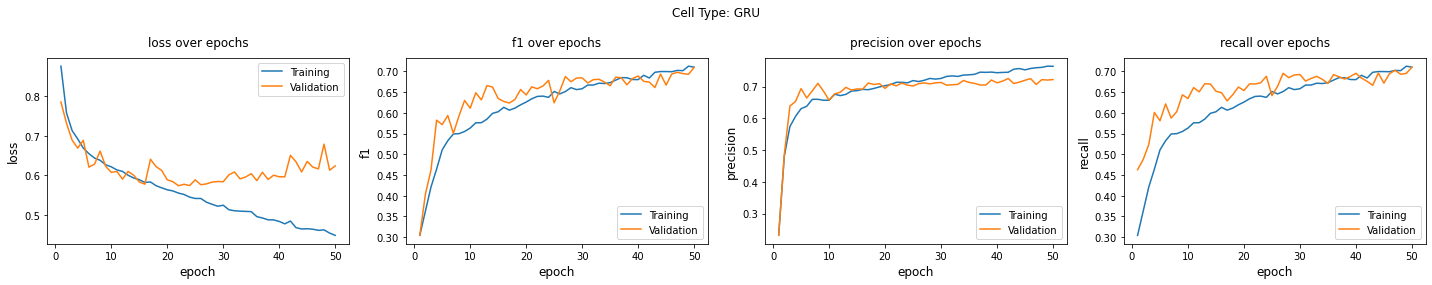

In [ ]:
# Hyperparameters (except number of cell type)
INPUT_DIM = len(X_field.vocab)                              # Vocabulary size (because the first layer is the embedding layer)
EMBEDDING_DIM = X_field.vocab.vectors.shape[1]              # Embeddings dimensions
HIDDEN_DIM = 64                                            # Number of features in the hidden state
OUTPUT_DIM = 3                                              # Number of distinct labels in our data
DROPOUT = 0.5                                               # Dropout probability
PAD_IDX = X_field.vocab.stoi[X_field.pad_token]             # <pad> token index
ATTENTION = False                                           # Adding attention or not
N_LAYERS = 2
GRAD_CLIP_VALUE = None

# Define the models 
model1 = BidirectionalRNN('RNN', INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT, PAD_IDX, ATTENTION).to(device)
model2 = BidirectionalRNN('LSTM', INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT, PAD_IDX, ATTENTION).to(device)
model3 = BidirectionalRNN('GRU', INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT, PAD_IDX, ATTENTION).to(device)

epochs = 50
for i, (cell_type,model) in enumerate([('RNN',model1),('LSTM',model2),('GRU',model3)]):
    # Define the loss function (use the weight parameter because the dataset is imbalanced)
    label_counts = train_data['label'].value_counts()
    weights_list = label_counts[0]/max(label_counts),label_counts[1]/max(label_counts),label_counts[2]/max(label_counts)
    loss_func = nn.NLLLoss(torch.Tensor(weights_list)).to(device)

    # Define the optimizer (use Adam because it is a requirement for the assignment)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

    # Train the Network
    train_scores, validation_scores = train_evaluate_network(buckit_train_dataloader, buckit_validation_dataloader, model, loss_func, optimizer, epochs, device, GRAD_CLIP_VALUE)

    # Plot Loss, F1 Score, Precision and Recall over Epochs for Training/Validation
    plot_scores(train_scores,validation_scores,epochs,f'Cell Type: {cell_type}')

It looks like, the vanilla RNN model has a hard fitting the training data, probably because of the vanishing/exploding gradient problems it encounters. The problem of vanishing gradients is mitigated by using LSTM/GRU cells, however in order to overcome the problem of exploding gradients we had to use the gradient clipping technique as shown below. When it comes to the comparison between LSTM and GRU we observed that they generally have very similar performances, but GRU is a lot faster when it comes to computational time (because of its greater simplicity compared to LSTM).

Let's see how **Gradient Clipping** affects our training/generalization.

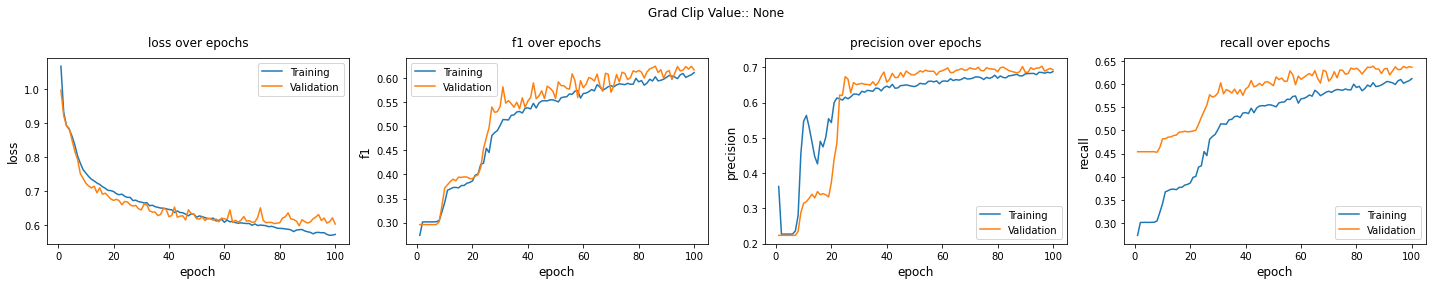

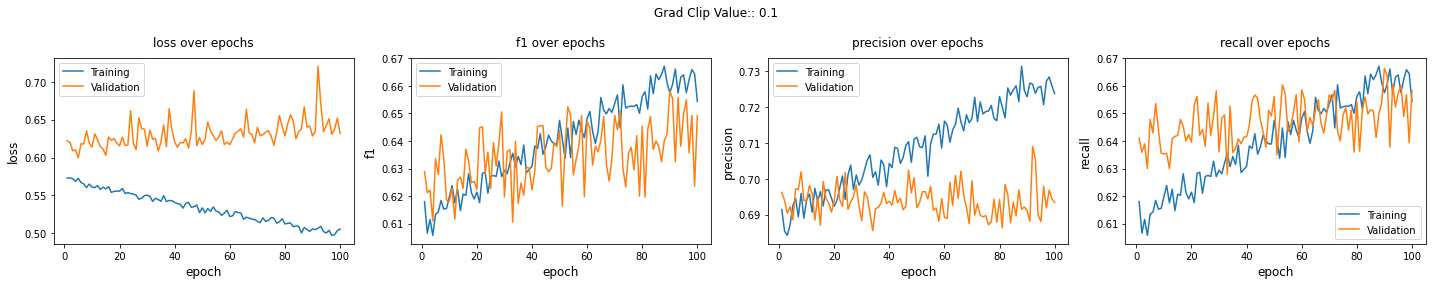

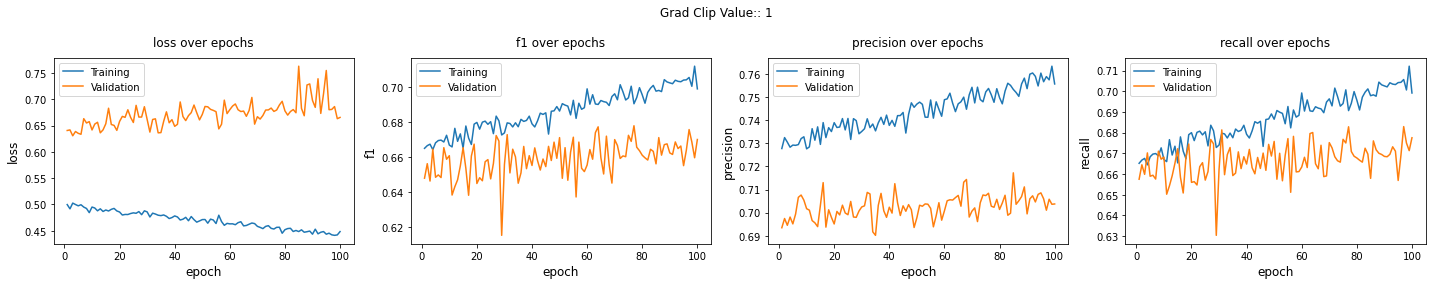

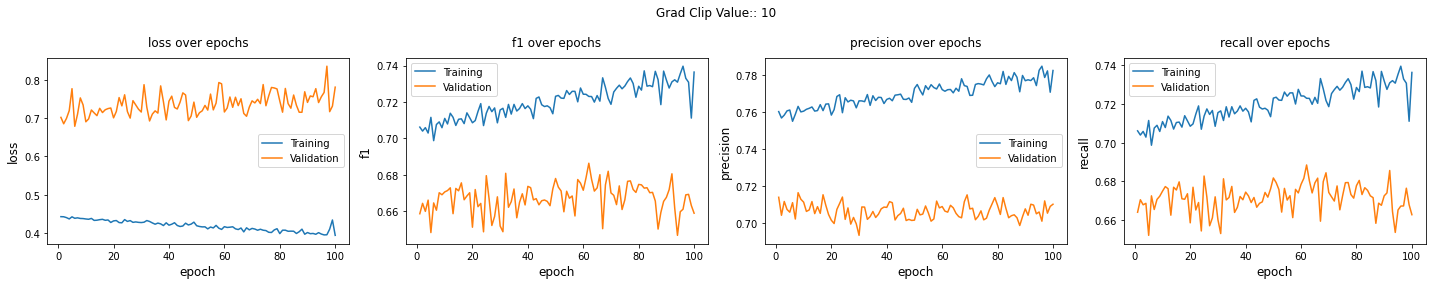

In [ ]:
# Hyperparameters (except gradient clipping)
CELL_TYPE = 'LSTM'
INPUT_DIM = len(X_field.vocab)                              # Vocabulary size (because the first layer is the embedding layer)
EMBEDDING_DIM = X_field.vocab.vectors.shape[1]              # Embeddings dimensions
HIDDEN_DIM = 64                                            # Number of features in the hidden state
OUTPUT_DIM = 3                                              # Number of distinct labels in our data
DROPOUT = 0.5                                               # Dropout probability
PAD_IDX = X_field.vocab.stoi[X_field.pad_token]             # <pad> token index
ATTENTION = False                                           # Adding attention or not
N_LAYERS = 2

# Define the models 
model = BidirectionalRNN(CELL_TYPE, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT, PAD_IDX, ATTENTION).to(device)

epochs = 100
for i, grad_clip_value in enumerate([None,0.1,1,10]):
    # Define the loss function (use the weight parameter because the dataset is imbalanced)
    label_counts = train_data['label'].value_counts()
    weights_list = label_counts[0]/max(label_counts),label_counts[1]/max(label_counts),label_counts[2]/max(label_counts)
    loss_func = nn.NLLLoss(torch.Tensor(weights_list)).to(device)

    # Define the optimizer (use Adam because it is a requirement for the assignment)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Train the Network
    train_scores, validation_scores = train_evaluate_network(buckit_train_dataloader, buckit_validation_dataloader, model, loss_func, optimizer, epochs, device, grad_clip_value)

    # Plot Loss, F1 Score, Precision and Recall over Epochs for Training/Validation
    plot_scores(train_scores,validation_scores,epochs,f'Grad Clip Value:: {grad_clip_value}')

Given the current values for the other hyperparameters, it looks like the use of gradient clipping is bad for our training. We kept these plots in order to make consistent comparisons regarding how each hyperparameter affects our training. It looks like, in general, employing the gradient clipping technique allows our model to fit better on the training data compared to the first model that doesn't use gradient clipping. However, if we don't adjust the values of the other hyperparameters according to the value we used for the gradient clipping, we end up overfitting. When it comes to the exact value for the clipping, we observed in our experiments that a value of 1 was (usually) our best choice.

Let's see how the **Dropout Probability** affects our training/generalization.

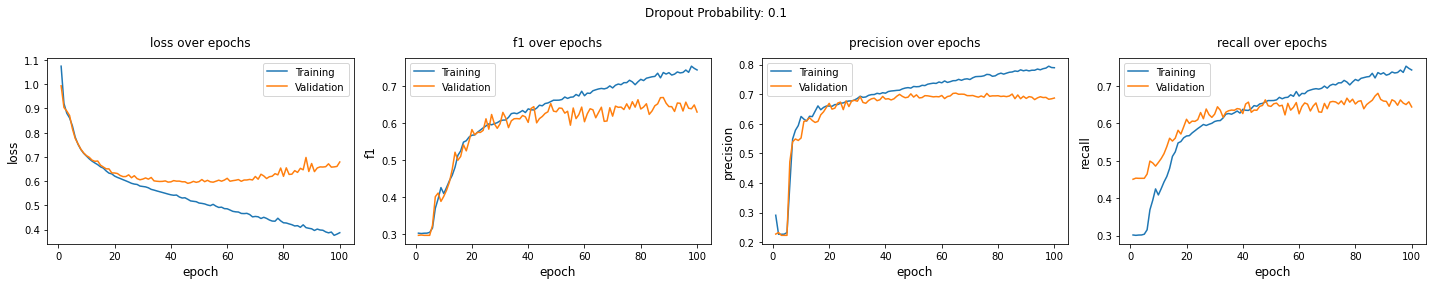

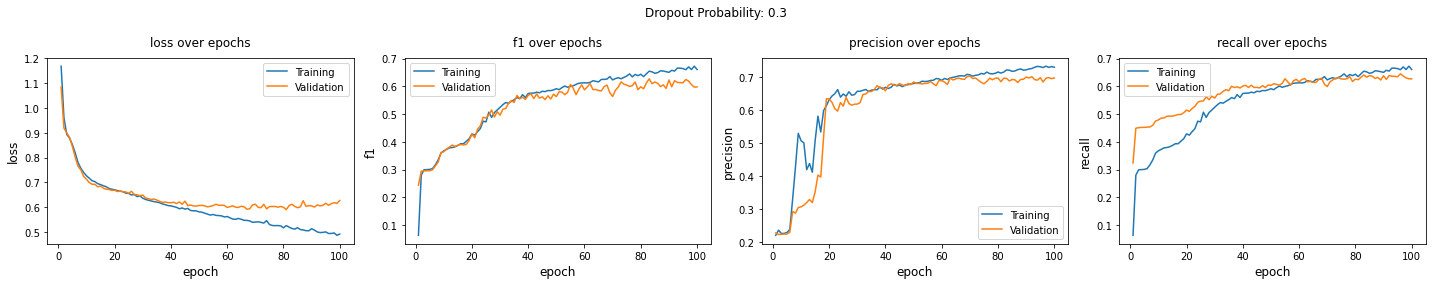

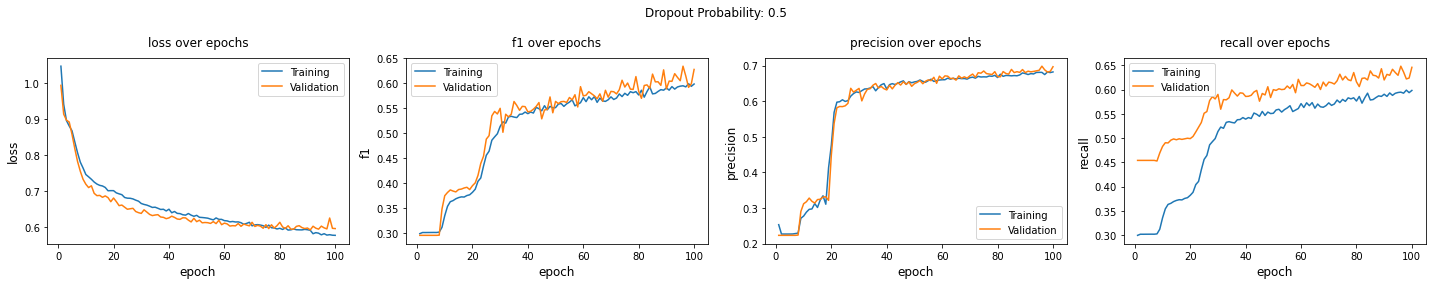

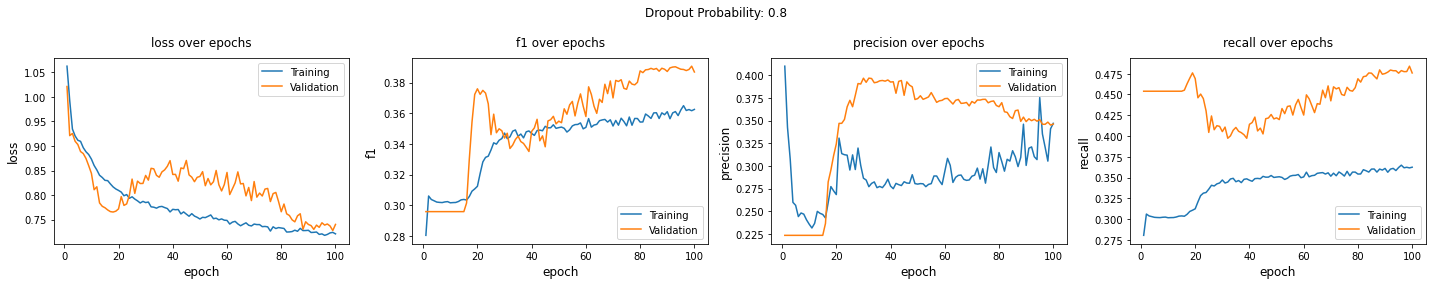

In [ ]:
# Hyperparameters (except dropout probability)
CELL_TYPE = 'LSTM'
INPUT_DIM = len(X_field.vocab)                              # Vocabulary size (because the first layer is the embedding layer)
EMBEDDING_DIM = X_field.vocab.vectors.shape[1]              # Embeddings dimensions
HIDDEN_DIM = 64                                            # Number of features in the hidden state
OUTPUT_DIM = 3                                              # Number of distinct labels in our data
PAD_IDX = X_field.vocab.stoi[X_field.pad_token]             # <pad> token index
ATTENTION = False                                           # Adding attention or not
N_LAYERS = 2
GRAD_CLIP_VALUE = 1

# Define the models 
model1 = BidirectionalRNN(CELL_TYPE, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, 0.1, PAD_IDX, ATTENTION).to(device)
model2 = BidirectionalRNN(CELL_TYPE, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, 0.3, PAD_IDX, ATTENTION).to(device)
model3 = BidirectionalRNN(CELL_TYPE, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, 0.5, PAD_IDX, ATTENTION).to(device)
model4 = BidirectionalRNN(CELL_TYPE, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, 0.8, PAD_IDX, ATTENTION).to(device)

epochs = 100
for i, (dropout_proba,model) in enumerate([(0.1,model1),(0.3,model2),(0.5,model3),(0.8,model4)]):
    # Define the loss function (use the weight parameter because the dataset is imbalanced)
    label_counts = train_data['label'].value_counts()
    weights_list = label_counts[0]/max(label_counts),label_counts[1]/max(label_counts),label_counts[2]/max(label_counts)
    loss_func = nn.NLLLoss(torch.Tensor(weights_list)).to(device)

    # Define the optimizer (use Adam because it is a requirement for the assignment)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

    # Train the Network
    train_scores, validation_scores = train_evaluate_network(buckit_train_dataloader, buckit_validation_dataloader, model, loss_func, optimizer, epochs, device, GRAD_CLIP_VALUE)

    # Plot Loss, F1 Score, Precision and Recall over Epochs for Training/Validation
    plot_scores(train_scores,validation_scores,epochs,f'Dropout Probability: {dropout_proba}')

It is quite obvious from the plots that a very small value for the dropout probability results to low bias but very high variance (and therefore probably bad generalization for our model) and a very large value for the dropout probability results in very high bias (our model barely learns). Our best choice would be somewhere between 0.3 and 0.6 depending on the values of the other hyperparameters.

As we mentioned in the report, hyperparameter tuning is not a sequential process. We can't expect to configure the value of one hyperparameter without making assumptions bout the values of the others. In our above plots, when plotting the effect of each hyperparameter, we made huge assumptions about the values of the other hyperparameters (we didn't know whether these values are optimal), but we did present the above plots to show the **general effect** that the increase or decrease of the value of a particular hyperparameter would have on the model's training/generalization. For example, this way we could observe the general effect that the dropout probability has on our network, which is that decreasing the value decreases the bias (allows for better fitting on the training set) but increases the variance, whereas increasing the dropout probability decreases the variance but also the bias (makes it harder for our model to learn). 

The best value for each hyperparameter is a **relative concept**, it depends on where we are now and where we want to go. So, for example, if I saw that my current model was underfitting the data I would probably decrease the dropout probability to allow it to learn better. This is the way we tuned our best model. We started with a base model that though had a theoritical basis to perform well and we gradually fine-tuned it depending on where we wanted to go each time (and as we said, this process required us to change of the values of the same hyperparameters even if we 'thought' these were the best for **that moment**).

# Error Analysis (Evaluation of Best Model on the -Validation- Set)

In [14]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import seaborn as sns

def plot_confusion_matrix(y_validation,predictions_validation):
    normalized_confusion_matrix = confusion_matrix(y_validation, predictions_validation) / confusion_matrix(y_validation, predictions_validation).sum(axis=1, keepdims=True)
    fig, ax = plt.subplots(figsize=(10,8))
    sns.heatmap(normalized_confusion_matrix, annot=True, cmap=plt.cm.gray, xticklabels=label_sentiments.values(), yticklabels=label_sentiments.values())
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Validation Confusion Matrix')
    plt.show()
    
def print_wrong_examples(y_validation,predictions_validation):
    normalized_confusion_matrix = confusion_matrix(y_validation, predictions_validation) / confusion_matrix(y_validation, predictions_validation).sum(axis=1, keepdims=True)
    print("Examples of Wrong Classification in Validation:\n")
    for actual in label_sentiments.keys():
      for predicted in label_sentiments.keys():
        if actual != predicted and normalized_confusion_matrix[actual, predicted] > 0.2:       # Print only examples of label pairs with >20% confusion rate in the matrix
            print(f"\n'{label_sentiments[actual]}' Predicted as '{label_sentiments[predicted]}' - {round(100*normalized_confusion_matrix[actual, predicted])}% Confusion Rate:\n")
            for index,row in validation_data.loc[(y_validation == actual) & (predictions_validation == predicted)].head().iterrows():
                print(f"Index: {index} - Tweet: {row['tweet']}")
                
def print_top_ngrams(preparation_pipeline, model, N=6):         
    """
    Prints the most top N most correlated n-grams for each of the labels.
    (according to the learned θ parameters of the classification model)
    preparation_pipeline = The pipeline used to preprocess the data
                          (we need this for the ngrams used and the
                          feature_names of the vectorizer)
    model = This is the softmax regression model whose θ parameters we use
            to find the top n-grams
    N = The number of top n-grams to print e.g. the top 6 uni-grams and bi-grams
    """
    vectorizer = preparation_pipeline['vectorization'].vectorizer          # Get the vectorizer instance from the pipeline
    ngram_range = preparation_pipeline['vectorization'].ngram_range        # Get the value of the ngrams parameter in pipeline's vectorizer
    for label in label_sentiments.keys():
        indices = np.argsort(model.coef_[label])                           # Sort the model's learned coefficients θ (for each label) from lowest to highest and get their -indices-
        feature_names = np.array(vectorizer.get_feature_names())[indices]  # Get the words themselves (from the chosen vectorizer) corresponding to each index/coefficient
        print(f"\nIn '{label_sentiments[label]}' Tweets:")
        for n in range(ngram_range[0],ngram_range[1]+1):                   # Convert the ngram_range tuple to a range of numbers e.g. (1,3) = 1,2,3
            n_grams = [v for v in reversed(feature_names) if len(v.split(' ')) == n][:N]
            print("  Top {}-grams:\n      - {}".format(n,'\n      - '.join(n_grams))) 

def plot_roc_curve(y_validation,predictions_validation_probabilities):
    # Binarize the output
    y_true = label_binarize(y_validation, classes=[0, 1, 2])
    n_classes = y_true.shape[1]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw=2
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], predictions_validation_probabilities.cpu().numpy()[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve of class {0} (area = {1:0.2f})' ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

Train our best model

BidirectionalRNN(
  (embedding): Embedding(14031, 200, padding_idx=1)
  (rnn): LSTM(200, 64, num_layers=2, dropout=0.6, bidirectional=True)
  (dropout): Dropout(p=0.6, inplace=False)
  (dense): Linear(in_features=128, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=3, bias=True)
  (relu): ReLU()
  (attention): Linear(in_features=128, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=1)
)


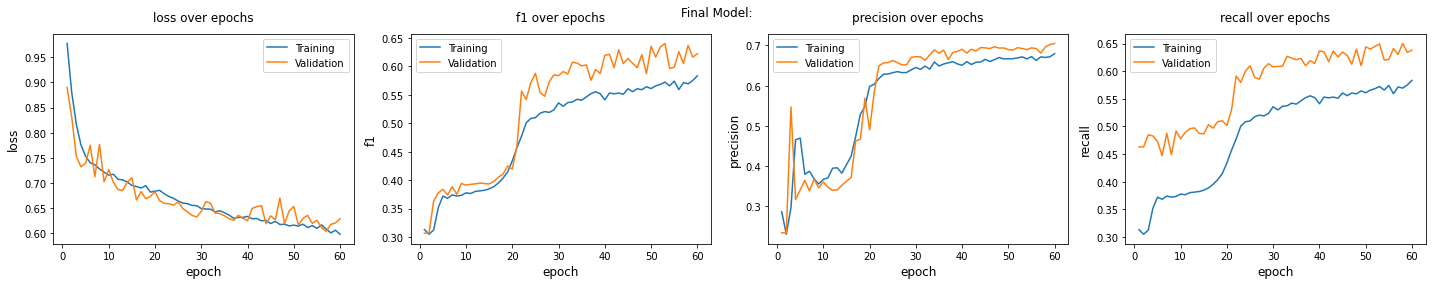

In [15]:
# Hyperparameters
CELL_TYPE = 'LSTM'                                          # Type of reccurent layer cell
INPUT_DIM = len(X_field.vocab)                              # Vocabulary size (because the first layer is the embedding layer)
EMBEDDING_DIM = X_field.vocab.vectors.shape[1]              # Embeddings dimensions
HIDDEN_DIM = 64                                            # Number of features in the hidden state
OUTPUT_DIM = 3                                              # Number of distinct labels in our data
N_LAYERS = 2                                                # Number of recurrent layers (i.e. stacked RNNs)
DROPOUT = 0.6                                               # Dropout probability
PAD_IDX = X_field.vocab.stoi[X_field.pad_token]             # <pad> token index
ATTENTION = False                                           # Adding attention or not
GRAD_CLIP_VALUE = 1

# Model Definition
final_model = BidirectionalRNN(CELL_TYPE, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT, PAD_IDX, ATTENTION).to(device)
print(final_model)

# Define the loss function (use the weight parameter because the dataset is imbalanced)
label_counts = train_data['label'].value_counts()
weights_list = label_counts[0]/max(label_counts),label_counts[1]/max(label_counts),label_counts[2]/max(label_counts)
loss_func = nn.NLLLoss(torch.Tensor(weights_list)).to(device)

# Define the optimizer (use Adam because it is a requirement for the assignment)
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.0001)
epochs = 60

# Train the Network
train_scores, validation_scores = train_evaluate_network(buckit_train_dataloader, buckit_validation_dataloader, final_model, loss_func, optimizer, epochs, device, GRAD_CLIP_VALUE)

# Plot Loss, F1 Score, Precision and Recall over Epochs for Training/Validation
plot_scores(train_scores,validation_scores,epochs,f'Final Model:')

Predict on the validation set and do some error analysis

In [16]:
predictions_validation_probabilities = torch.empty((64,3),dtype=torch.float)
buckit_validation_dataloader.init_epoch()
final_model.eval()
with torch.no_grad():
    for i, batch in enumerate(buckit_validation_dataloader):
        (X,X_length), y = batch
        X = X.to(device)
        y = y.to(device)
        if i == 0:
            predictions_validation_probabilities = final_model(X, X_length)
        else:
            predictions_validation_probabilities = torch.cat((predictions_validation_probabilities,final_model(X, X_length)))
predictions_validation = predictions_validation_probabilities.argmax(1).cpu().numpy()
y_validation = full_validation['label'].to_numpy()

In [17]:
print(classification_report(y_validation, predictions_validation))

              precision    recall  f1-score   support

           0       0.47      0.57      0.52      1063
           1       0.12      0.18      0.14       294
           2       0.41      0.24      0.30       920

    accuracy                           0.39      2277
   macro avg       0.33      0.33      0.32      2277
weighted avg       0.40      0.39      0.38      2277



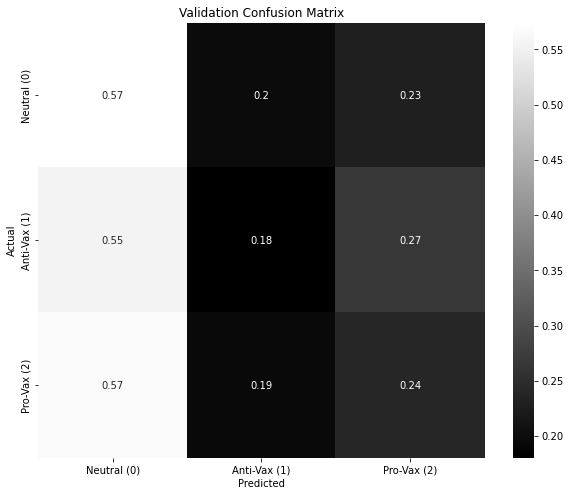

In [18]:
plot_confusion_matrix(y_validation, predictions_validation)

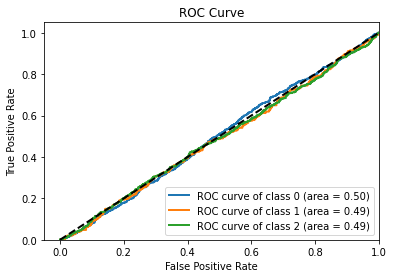

In [19]:
plot_roc_curve(y_validation,predictions_validation_probabilities)

Let's see what happens if we add **Attention** to our best model. 

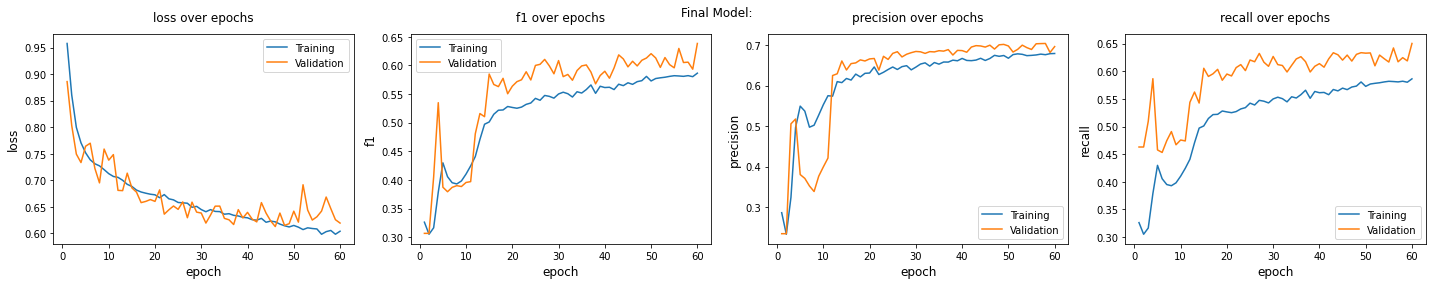

In [20]:
# Hyperparameters
CELL_TYPE = 'LSTM'                                          # Type of reccurent layer cell
INPUT_DIM = len(X_field.vocab)                              # Vocabulary size (because the first layer is the embedding layer)
EMBEDDING_DIM = X_field.vocab.vectors.shape[1]              # Embeddings dimensions
HIDDEN_DIM = 64                                             # Number of features in the hidden state
OUTPUT_DIM = 3                                              # Number of distinct labels in our data
N_LAYERS = 2                                                # Number of recurrent layers (i.e. stacked RNNs)
DROPOUT = 0.6                                               # Dropout probability
PAD_IDX = X_field.vocab.stoi[X_field.pad_token]             # <pad> token index
ATTENTION = True                                            # <------------------------
GRAD_CLIP_VALUE = 1

# Model Definition
attention_model = BidirectionalRNN(CELL_TYPE, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, N_LAYERS, DROPOUT, PAD_IDX, ATTENTION).to(device)

# Define the loss function (use the weight parameter because the dataset is imbalanced)
label_counts = train_data['label'].value_counts()
weights_list = label_counts[0]/max(label_counts),label_counts[1]/max(label_counts),label_counts[2]/max(label_counts)
loss_func = nn.NLLLoss(torch.Tensor(weights_list)).to(device)

# Define the optimizer (use Adam because it is a requirement for the assignment)
optimizer = torch.optim.Adam(attention_model.parameters(), lr=0.0001)
epochs = 60

# Train the Network
train_scores, validation_scores = train_evaluate_network(buckit_train_dataloader, buckit_validation_dataloader, attention_model, loss_func, optimizer, epochs, device, GRAD_CLIP_VALUE)

# Plot Loss, F1 Score, Precision and Recall over Epochs for Training/Validation
plot_scores(train_scores,validation_scores,epochs,f'Final Model:')

predictions_validation_probabilities = torch.empty((264,3),dtype=torch.float)
buckit_validation_dataloader.init_epoch()
attention_model.eval()
with torch.no_grad():
    for i, batch in enumerate(buckit_validation_dataloader):
        (X,X_length), y = batch
        X = X.to(device)
        y = y.to(device)
        if i == 0:
            predictions_validation_probabilities = attention_model(X, X_length)
        else:
            predictions_validation_probabilities = torch.cat((predictions_validation_probabilities,attention_model(X, X_length)))
predictions_validation = predictions_validation_probabilities.argmax(1).cpu().numpy()
y_validation = full_validation['label'].to_numpy()

In [21]:
print(classification_report(y_validation, predictions_validation))

              precision    recall  f1-score   support

           0       0.47      0.58      0.52      1063
           1       0.12      0.20      0.15       294
           2       0.39      0.21      0.27       920

    accuracy                           0.38      2277
   macro avg       0.33      0.33      0.31      2277
weighted avg       0.40      0.38      0.37      2277



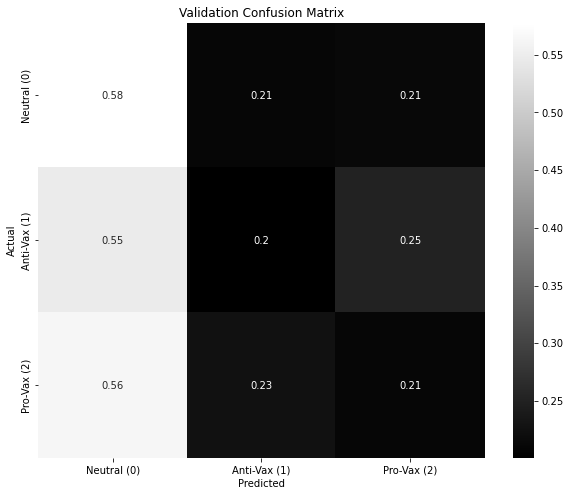

In [22]:
plot_confusion_matrix(y_validation, predictions_validation)

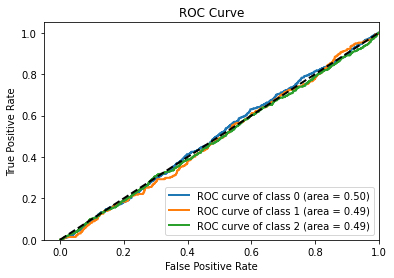

In [23]:
plot_roc_curve(y_validation,predictions_validation_probabilities)

Adding attention to our model slightly decreased the performance of our model, but it is barely noticeable (we'd say it actually didn't make any difference at all). This isn't what we expected but it makes sense given the tiny size of our dataset. Given a better dataset and probably different values for the other hyperparameters (adjusted to that dataset), we believe we would be able to see how attention would truly affect our learning positively.

We can see that the performance of our 'best' model is quite far from the performance we got in the previous exercise. Even though RNNs give us great strength because of their great theoritical basis on processing sequential data, we weren't able to showcase their superiority over simpler models. We believe that this is due to the tiny size of our dataset (around 10k training examples), which doesn't allow our network to learn. Somewhere in between trying to avoid overfitting and the very small size of the training dataset itself (which was also an overfitting reason in itself) we simplyfied our model in such a way that it had a very hard time fitting our data (as is evident by the the evaluation). We had a similar problem in FFNNs but back in the second assignment we managed to perform a lot better. The takeaway is that, even with the most sophisticated learning algorithms at the moment, we can't combat the problem of lack of data. The very small size of our training data didn't allow to show the true power of RNN networks.

# Final Model Evaluation on the Test Set

Predict on the test data

In [24]:
predictions_test_probabilities = torch.empty((64,3),dtype=torch.float)
buckit_test_dataloader.init_epoch()
final_model.eval()
with torch.no_grad():
    for i, batch in enumerate(buckit_test_dataloader):
        (X,X_length), y = batch
        X = X.to(device)
        y = y.to(device)
        if i == 0:
            predictions_test_probabilities = final_model(X, X_length)
        else:
            predictions_test_probabilities = torch.cat((predictions_test_probabilities,final_model(X, X_length)))
predictions_test = predictions_test_probabilities.argmax(1).cpu().numpy()
y_test = full_test['label'].to_numpy()

In [25]:
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       0.47      0.57      0.52      1063
           1       0.12      0.18      0.14       294
           2       0.41      0.24      0.30       920

    accuracy                           0.39      2277
   macro avg       0.33      0.33      0.32      2277
weighted avg       0.40      0.39      0.38      2277



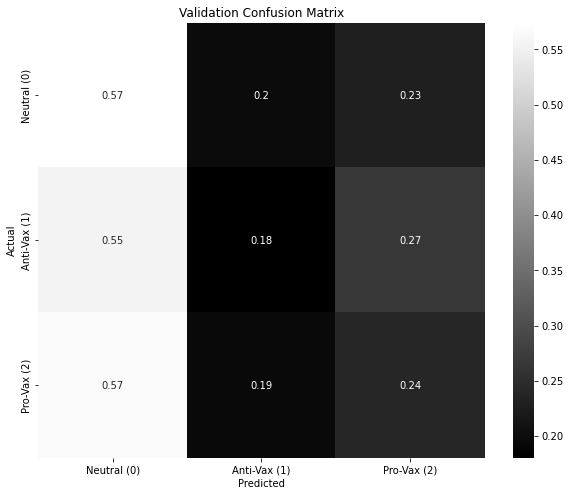

In [26]:
plot_confusion_matrix(y_test,predictions_test)

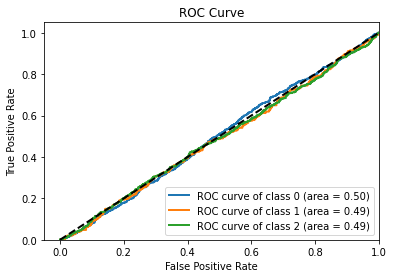

In [27]:
plot_roc_curve(y_test,predictions_test_probabilities)

# References

https://gmihaila.medium.com/better-batches-with-pytorchtext-bucketiterator-12804a545e2a

https://stackoverflow.com/questions/62291303/pytorch-loading-word-vectors-into-field-vocabulary-vs-embedding-layer?rq=1

https://www.nbshare.io/notebook/754493525/Tweet-Sentiment-Analysis-Using-LSTM-With-PyTorch/

https://galhever.medium.com/sentiment-analysis-with-pytorch-part-1-data-preprocessing-a51c80cc15fb

https://galhever.medium.com/sentiment-analysis-with-pytorch-part-4-lstm-bilstm-model-84447f6c4525

https://neptune.ai/blog/understanding-gradient-clipping-and-how-it-can-fix-exploding-gradients-problem

https://www.kaggle.com/robertke94/pytorch-bi-lstm-attention